# Antibiotic Collateral Senstivity is Contingent on the Repeatability of Evolution

Presented below is the Python code used to analyse the MIC data derived from experimental evolution outlined in __Antibiotic Collateral Senstivity is Contingent on the Repeatability of Evolution__. This work appeared also as a preprint: __Nichol, Daniel, et al. "Collateral sensitivity is contingent on the repeatability of evolution." bioRxiv (2017): 185892.__

In this notebook we provide the derivation of the measurement error probability $e$. We also provide the code used to perform the likelihood ratio test for comparing MIC values between parental and evolved line. Note that this methodology is adapted from __Weinreich, D. M., Delaney, N. F., DePristo, M. A. & Hartl, D. L. Darwinian evolution can follow only very few mutational paths to fitter proteins. Science 312, 111–114 (2006).__ (Supplementary Materials)

## Prerequisites

In [1]:
from copy import deepcopy
import sys

import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import scipy as sp
from scipy.stats import chi2 #For the LR rest
import seaborn as sns
sns.set_style('ticks')

print "Python version: ", sys.version
print "Matplotlib version: ", mpl.__version__
print "numpy version: ", np.__version__
print "pandas version: ", pd.__version__
print "scipy version:", sp.__version__
print "Seaborn version: ", sns.__version__

%matplotlib inline

Python version:  2.7.13 |Anaconda custom (x86_64)| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Matplotlib version:  2.1.0
numpy version:  1.13.1
pandas version:  0.23.1
scipy version: 0.19.1
Seaborn version:  0.7.1


## Loading the data
We first load the raw MIC measurements provided in Supplementary Table 2 and discard the p-values (which are derived in this notebook). Note that this notebook already contains the mle estimates for the MIC which are derived as outlined in the Methods.

In [2]:
df = pd.read_excel('./data/Supplementary Table 2.xls')
drug_names=['CTX', 'CIP', 'SAM', 'GNT', 'TIC', 'PMC', 'CFT', 'CFZ', 'PIP']
df_pvals = df[[c for c in df.columns if 'pval' in c]]

#Discard the mles and p-vals
df = df[[c for c in df.columns if 'pval' not in c]]

### 1. Calculate the alternative model MLE estimate for $e$

Note that throughout the following we use 'alternative model' to refer to the model that is alternative to the null hypothesis (i.e. the more general model in which the MIC between the evolved and parental lines differ.)

In [3]:
#1. Calculate the alt model mle for p (i.e. determine r,s,t,u)

def get_e_mle():
    r,s,t,u = 0,0,0,0
    for dn in drug_names:
        data = df[[c for c in df.columns if dn in c]]
        for k, ix in enumerate(data.index):
            y_1 = data[dn+'_1'].loc[ix]
            y_2 = data[dn+'_2'].loc[ix]
            y_3 = data[dn+'_3'].loc[ix]
            m   = data[dn+'_mle'].loc[ix]
    
            matches = sum([(y_1==m), (y_2==m), (y_3==m)])
            if matches==3:
                r+=1
            elif matches==2:
                s+=1
            elif matches==1:
                t+=1
            elif matches==0:
                u+=1
            else:
                print "ERROR two measurement differ by >4x, violating the model assumptions"

    return r,s,t,u

r,s,t,u = get_e_mle()
print r,s,t,u
e_alt = (s + 2*t + 3*u) / (3.*(r+s+t+u))
print "The mle for the error rate is: ", e_alt

338 196 11 4
The mle for the error rate is:  0.139647844566


### 2. We determine the log-likelihood for the alternative model

In [4]:
#2. Determine the mle log-likelihood for the alt model (our actual model)
def alt_mle():
    ll = 0.
    for dn in drug_names:
        data = df[[c for c in df.columns if dn in c]]
        
        #This evaluates the log of the likelihood in eqn 3
        for k, ix in enumerate(data.index):
            y_1 = data[dn+'_1'].loc[ix]
            y_2 = data[dn+'_2'].loc[ix]
            y_3 = data[dn+'_3'].loc[ix]
            m   = data[dn+'_mle'].loc[ix]
            for y in [y_1, y_2, y_3]:
                if y==m:
                    ll+=np.log(1-e_alt)
                elif y==(m/2) or y==(2*m):
                    ll+=np.log(e_alt/2.)
                else:
                    print "ERROR two measurement differ by >4x, violating the model assumptions"

    return ll

ll = alt_mle()
print ll

-825.344994437


### 3. How to find the MLE log-likelihood for a null model.
The null model assumes that a given replicate has MIC equal to the parental line, for a specific drug.

In [5]:
# How to find the mle log-likelihood for the null model
# (i.e. on in which we assume Xk has equal MIC to Parental)
def null_mle(df, k, dname):
    df_null = deepcopy(df)
    
    #Find the data sets that we assume have equal MIC
    data_parental = df_null[[c for c in df_null.columns if dname in c and 'mle' not in c]].iloc[0]
    data_replicate = df_null[[c for c in df_null.columns if dname in c and 'mle' not in c]].iloc[k]
    
    # If the variance is too high return -inf (i.e. L = 0)
    # This happens when the set of six measurement (3x parental + 3Xk)
    # have values that differ by >4x which breaks the model assumptions)=
    all_data=np.concatenate([data_parental.values,data_replicate.values])
    if 4*min(all_data) < max(all_data):
        return -1*np.inf

    # Otherwise we find the mle for the model in which the 
    # parental MICs are assume equal to the replicate MICs.
    # All other MIC valyes remainas before.
    
    # If the min of the 6 data points is 4x the max
    # then take the middle value
    if 4*min(all_data)==max(all_data):
        m = 2*min(all_data) 
    # Otherwise take the middle value
    # (usually the median but not where the median lies between two points)
    else:
        m = sorted(all_data)[2] #Else take the median (rounded to one of the possible MIC
            
    #Update the mle MIC in the df
    df_null.at['Parent', dname+'_mle']=m
    df_null.at['X'+str(k), dname+'_mle']=m

    #Then determine the new mle for e (i.e. calculate the new r,s,t,u)
    r,s,t,u = 0,0,0,0
    for dn in drug_names:
        data = df_null[[c for c in df_null.columns if dn in c]]
        for k, ix in enumerate(data.index):
            y_1 = data[dn+'_1'].loc[ix]
            y_2 = data[dn+'_2'].loc[ix]
            y_3 = data[dn+'_3'].loc[ix]
            m   = data[dn+'_mle'].loc[ix]
    
            matches = sum([(y_1==m), (y_2==m), (y_3==m)])
            if matches==3:
                r+=1
            elif matches==2:
                s+=1
            elif matches==1:
                t+=1
            elif matches==0:
                u+=1
            else:
                print "ERROR two measurement differ by >4x, violating the model assumptions"

    e_null = (s + 2*t + 3*u) / (3.*(r+s+t+u))
    
    #Finally, calculate the new mle Log-L value
    ll = 0.
    for dn in drug_names:
        data = df_null[[c for c in df_null.columns if dn in c]]
        for k, ix in enumerate(data.index):
            y_1 = data[dn+'_1'].loc[ix]
            y_2 = data[dn+'_2'].loc[ix]
            y_3 = data[dn+'_3'].loc[ix]
            m   = data[dn+'_mle'].loc[ix]
            for y in [y_1, y_2, y_3]:
                if y==m:
                    ll+=np.log(1-e_alt)
                elif y==(m/2) or y==(2*m):
                    ll+=np.log(e_alt/2.)
                else:
                    print "ERROR two measurement differ by >4x, violating the model assumptions"
                    print "Debug: ",dn,k,y_1,y_2,y_3,m
    return ll

### 4. Determine the p-vals by a likelihood ratio test

As the alternative model is a more general version of the null, the test-statistic
\begin{equation*}
    D = 2 \times \left[ \log(\mathcal{L}_\text{alt}) - \log(\mathcal{L}_\text{null}) \right]
\end{equation*}
is approximately $\chi^2$ distributed with 1-degrees of freedom (as the alternative model has one more parameter than the null). Thus we can compute p-values as follows

In [6]:
pmatrix= []
for k, ix in enumerate(df.index):
    row = []
    for dn in drug_names:
        if k!=0: #Skip the parental
            nl = null_mle(df, k, dn)
            D = 2*(ll - nl)
            p_val = chi2.sf(D, 1)
        else:
            p_val = np.NaN

        row.append(p_val)
    pmatrix.append(row)
        
df_pvals2 = pd.DataFrame(data=pmatrix, index=df.index, columns=drug_names)

In [7]:
total_comps = 540. #60 replicates * 9 drugs

#Testing for significance at alpha=0.05 with BF correction:
df_pvals2 < 0.05/total_comps

,CTX,CIP,SAM,GNT,TIC,PMC,CFT,CFZ,PIP
Parent,False,False,False,False,False,False,False,False,False
X1,True,True,True,False,True,False,True,True,False
X2,True,False,False,False,False,False,False,True,False
X3,True,False,True,False,True,True,True,True,True
X4,True,False,False,False,False,False,True,True,False
X5,True,False,True,False,True,True,True,True,False
X6,True,False,False,False,False,False,True,True,False
X7,True,False,False,False,True,True,True,True,False
X8,True,False,True,False,True,True,True,True,False
X9,True,False,True,False,True,True,True,True,False


## Figure 4 - Plotting

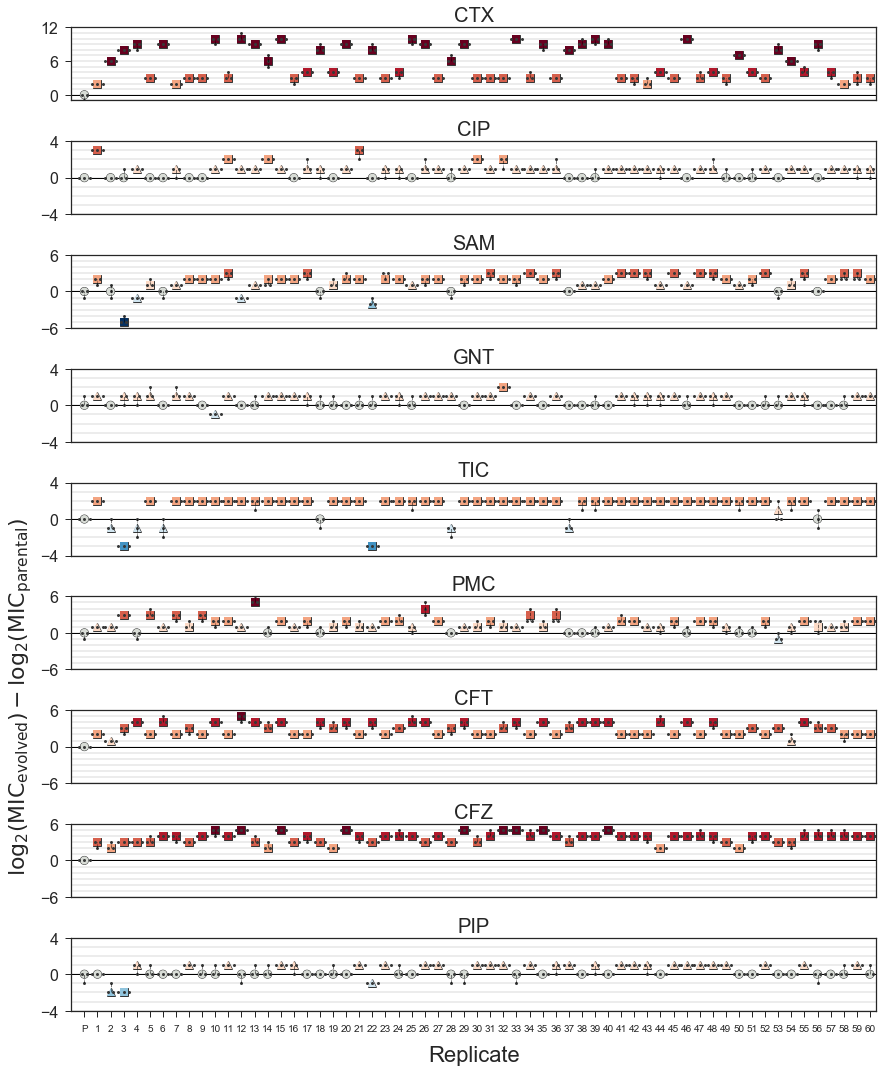

In [8]:
xlims = [(-1,12),(-4,4), (-6,6), (-4,4), (-4,4), (-6,6), (-6,6), (-6,6), (-4,4)]
alpha = 0.05 #Threshold for significance (uncorrected)

fig=plt.figure(figsize=(12,15))
for ix, d in enumerate(drug_names):
    plt.subplot(len(drug_names), 1, ix+1)
    #Plot the wild-type
    mles = np.log2(df[[d+'_mle']].values)
    d1s =  np.log2(df[[d+'_1']].values)
    d2s =  np.log2(df[[d+'_2']].values)
    d3s =  np.log2(df[[d+'_3']].values)

    #Determines the color for the mle point
    #CS colorbar OR grey is N.S
    norm = mpl.colors.Normalize(vmin=-5, vmax=5)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)
    cmap.set_array([])

    def get_pcol(i):
        if df_pvals2[d].iloc[i] < alpha/total_comps: #BF correction
            cs_val = mles[0] - mles[i]
            pcol = cmap.to_rgba(cs_val)[0]
            marker='s'
        elif df_pvals2[d].iloc[i] < alpha: #NS after BF correction
            cs_val = mles[0] - mles[i]
            pcol = cmap.to_rgba(cs_val)[0]
            marker='^'
        else: #NS
            pcol = sns.xkcd_rgb['light grey']
            marker='o'
        return marker, pcol
    point_col = sns.xkcd_rgb['dark grey']

    #How to move the smaller points
    def wiggle(d1,d2,d3):
        if d1==d2 and d2==d3:
            return 0, 0.4, -0.4
        elif d1==d2:
            return 0.2, -0.2, 0.0
        elif d2==d3:
            return 0.0,0.2,-0.2
        elif d1==d3:
            return 0.2,0.0,-0.2
        else:
            return 0,0,0,

    #Grid and zero marker
    plt.gca().axhline(mles[0]-mles[0], ls='-', c='k', lw=1.0)
    for lk in range(-20,20):
        plt.gca().axhline(lk, ls='-', c='k', lw=0.3, alpha=0.5)

    for i in range(0,61):
        d1,d2,d3 = d1s[i], d2s[i], d3s[i]
        i1,i2,i3 = wiggle(d1,d2,d3)

        marker, pcol = get_pcol(i)

        plt.plot([i], mles[i]-mles[0], marker=marker, ls='', c=pcol, ms=8, alpha=1.0,
                path_effects=[pe.Stroke(linewidth=1, foreground=point_col), pe.Normal()])
        plt.plot([i+i1], d1-mles[0], marker='o', ls='', c=point_col, ms=3)
        plt.plot([i+i2], d2-mles[0], marker='o', ls='', c=point_col, ms=3)
        plt.plot([i+i3], d3-mles[0], marker='o', ls='', c=point_col, ms=3)

        plt.plot([i,i],[min([d1,d2,d3]-mles[0]), max([d1,d2,d3])-mles[0]], c='k', ls='-.', lw=0.5)

    if ix==len(drug_names)-1:
        plt.xticks(range(61), ['P']+map(lambda x : str(x), range(1, 61)))
        plt.xlabel('Replicate', size=22, labelpad=12.0)
    else:
        plt.xticks([])

    plt.xlim(-1.0,60.5)
    
    plt.ylim(xlims[ix])
    if ix>0:
        plt.yticks([min(xlims[ix]), 0, max(xlims[ix])], size=16)
    else:
        plt.yticks([0,6,12], size=16)

    plt.title(d, size=20)

lab = fig.text(-0.01, 0.5, 
               r'$\log_{2}(\mathrm{MIC}_{\mathrm{evolved}}) - \log_{2}(\mathrm{MIC}_{\mathrm{parental}})$',
               ha='center', size=22, rotation=90)


plt.tight_layout()
plt.savefig('./stacks_cs.svg');

## Figure 5 - Plotting

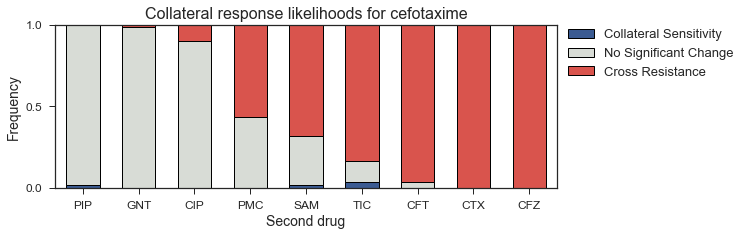

In [12]:
data = []
for ix, d in enumerate(drug_names):
    ds = [0,0,0]
    mles = np.log2(df[[d+'_mle']].values)
    
    def get_sig(i):
        if df_pvals2[d].iloc[i] < alpha/total_comps: #BF correction
            return True
        else:
            return False
    
    for i in range(1,61):
        if not get_sig(i):
            ds[1]+=1
        else:
            if mles[0] > mles[i]:
                ds[0]+=1
            else:
                ds[2]+=1
    data.append(ds)
    
#Sort the bars
drugs2, data = zip(*sorted(zip(drug_names, data), key=lambda x : -1*sum(x[1][:2])))

w=0.6
plt.figure(figsize=(9,3))
for ix, ds in enumerate(data):
    if ix==0:
        labels = ['Collateral Sensitivity', 'No Significant Change', 'Cross Resistance']
    else:
        labels = ['','','',]
    plt.bar([ix], ds[0], facecolor=sns.xkcd_rgb['denim blue'], lw=1., 
            edgecolor='k', width=w, label=labels[0])
    plt.bar([ix], ds[1], bottom=ds[0], facecolor=sns.xkcd_rgb['light grey'], lw=1., 
            edgecolor='k', width=w, label=labels[1])
    plt.bar([ix], ds[2], bottom=ds[0]+ds[1], facecolor=sns.xkcd_rgb['pale red'], lw=1., 
            edgecolor='k', width=w, label=labels[2])

# plt.plot([100], [100], marker='o', ls='', label='Collateral Sensitivity', c=sns.xkcd_rgb['denim blue'])
    
plt.xticks(range(len(drug_names)), drugs2, size=12)
plt.yticks([0,30,60], [0.0,0.5,1.0], size=12)
plt.xlim(-0.5,len(drug_names)-0.5)
plt.ylim(0,60)

plt.legend(loc=4, bbox_to_anchor=(0.375, 0.6, 1.0,1.0), fontsize=13)
plt.title('Collateral response likelihoods for cefotaxime', size=16)

plt.xlabel('Second drug', size=14)
plt.ylabel('Frequency', size=14)
plt.savefig('./csl_freqs.svg');